In [1]:
# docker container start hfpt_July21

#### Start with the imports

In [2]:
import os

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from IPython.display import display

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
# from torchsummary import summary
from torchinfo import summary
from tqdm import tqdm

In [3]:
!ls /tf/All/Data/Kaggle/Chest_X-ray_Images

test  train


In [4]:
# root folder of the data directory
dataDir = '/tf/All/Data/Kaggle/Chest_X-ray_Images'

#### Explore the data

In [5]:
# 2 types of x-rays ...
class_name = ['NORMAL','PNEUMONIA']

In [6]:
def get_list_files(dirName):
    files_list = os.listdir(dirName)
    return files_list

In [7]:
trainDir = dataDir + '/train/'
testDir = dataDir + '/test/'
print(trainDir)
print(testDir)

/tf/All/Data/Kaggle/Chest_X-ray_Images/train/
/tf/All/Data/Kaggle/Chest_X-ray_Images/test/


In [8]:
files_list_normal_train = get_list_files(trainDir + class_name[0])
files_list_pneu_train = get_list_files(trainDir + class_name[1])

In [9]:
files_list_normal_test = get_list_files(testDir + class_name[0])
files_list_pneu_test = get_list_files(testDir + class_name[1])

In [10]:
print("Number of train samples in Normal category {}".format(len(files_list_normal_train)))
print("Number of train samples in Pneumonia category {}".format(len(files_list_pneu_train)))

Number of train samples in Normal category 1349
Number of train samples in Pneumonia category 3883


In [11]:
print("Number of test samples in Normal category {}".format(len(files_list_normal_test)))
print("Number of test samples in Pneumonia category {}".format(len(files_list_pneu_test)))

Number of test samples in Normal category 234
Number of test samples in Pneumonia category 390


In [12]:
## get random file to check
img = dataDir + '/train/NORMAL/'+ files_list_normal_train[np.random.randint(0,len(files_list_normal_train))]
print(plt.imread(img).shape)

(1468, 1844)


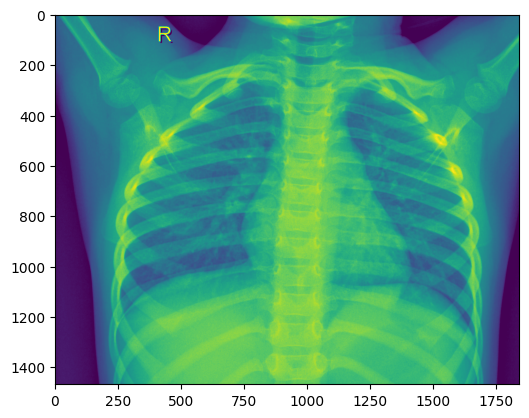

In [13]:
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

(792, 1376)


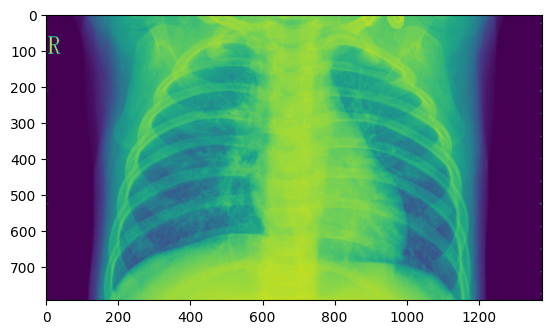

In [14]:
## get random file to check pneumona 
img = dataDir + '/train/PNEUMONIA/'+ files_list_pneu_train[np.random.randint(0,len(files_list_pneu_train))]
print(plt.imread(img).shape)
#display(Image.open(img,'r'),)

img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

In [15]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

In [16]:
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

In [17]:
# getting the train and test data loader in place
train_data = datasets.ImageFolder(os.path.join(dataDir, 'train'), transform=train_transform)

In [18]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True)

In [19]:
class_names = train_data.classes
class_names

['NORMAL', 'PNEUMONIA']

In [20]:
test_data = datasets.ImageFolder(os.path.join(dataDir, 'test'), transform=test_transform)

In [21]:
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, pin_memory=True)

In [22]:
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

Number of train images: 5232
Number of test images: 624


#### Define the Model

In [23]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), 
                      padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(4)
        ) 
        self.pool11 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK 
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3),
                      padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(16)
        ) 

        # TRANSITION BLOCK 

        self.pool22 = nn.MaxPool2d(2, 2) 

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(10),
            nn.ReLU()
        ) 
        self.pool33 = nn.MaxPool2d(2, 2) 
        

        # CONVOLUTION BLOCK 
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(10)
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
           
        ) 

        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(10),
            
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(10)
         
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            
            nn.ReLU(),
            #nn.BatchNorm2d(32)
        )

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(10),
            
        ) 

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(14),
            
        ) 

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(16),
            
        ) 
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) 

        self.convblockout = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=False),

        ) 



    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)        
        x = self.convblockout(x)

        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)

In [24]:
# and of course, use cuda when you can!
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [25]:
model = Net().to(device)

In [26]:
summary(model, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 2]                    --
├─Sequential: 1-1                        [8, 222, 222]             --
│    └─Conv2d: 2-1                       [8, 222, 222]             216
│    └─ReLU: 2-2                         [8, 222, 222]             --
├─MaxPool2d: 1-2                         [8, 111, 111]             --
├─Sequential: 1-3                        [16, 109, 109]            --
│    └─Conv2d: 2-3                       [16, 109, 109]            1,152
│    └─ReLU: 2-4                         [16, 109, 109]            --
├─MaxPool2d: 1-4                         [16, 54, 54]              --
├─Sequential: 1-5                        [10, 54, 54]              --
│    └─Conv2d: 2-5                       [10, 54, 54]              160
│    └─ReLU: 2-6                         [10, 54, 54]              --
├─MaxPool2d: 1-6                         [10, 27, 27]              --
├─Sequenti

#### Training Process